# Enforcing non-negative maps
Perhaps the simplest prior we can place on the surface map of a body is that its intensity not be negative anywhere. As we discuss in the paper, this is trivial to enforce for $l = 0$ and $l = 1$ maps, but can be tricky for higher degree maps since the problem is not analytic. Still, `starry` can efficiently determine whether a map is positive semi-definite (*PSD*) via the `map.psd()` method, which returns `True` if the map is physical (non-negative everywhere) and `False` otherwise (negative somewhere).

To showcase this, let's investigate the values of the coefficients of maps of different degree that guarantee positive semi-definiteness. We'll run a very simple MCMC chain with a likelihood definied to be 1 if the map is *PSD* and 0 otherwise.

In [1]:
import starry
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
import emcee
from tqdm import tqdm
import corner

In [2]:
def lnlike(p, map, l, max_iterations=100):
    """Compute the log likelihood."""
    # Set the coeffs
    n = 0
    for m in range(-l, l + 1):
        map[l, m] = p[n]
        n += 1
        
    # Determine if it is positive semi-definite
    if map.psd(max_iterations=max_iterations):
        return 0
    else:
        return -np.inf

    
def compute(l=1, nsteps=10000, scale=1e-4, max_iterations=100):
    """Run MCMC to find the PSD regions of parameter space."""
    # Instantiate the map
    map = starry.Map(l)
    map[0, 0] = 1

    # Run MCMC
    ndim = 2 * l + 1
    nwalk = ndim * 2
    p0 = [scale * np.random.randn(ndim) for k in range(nwalk)]
    sampler = emcee.EnsembleSampler(nwalk, ndim, lnlike, args=[map, l, max_iterations])
    for i in tqdm(sampler.sample(p0, iterations=nsteps), total=nsteps):
        pass

    # Plot the corner plot
    labels = [r"$y_{%d,%d}$" % (l, m) for m in range(-l, l+1)]
    samples = sampler.flatchain[np.where(sampler.flatlnprobability == 0)]
    fig = corner.corner(samples, labels=labels, bins=50);
    for ax in fig.axes:
        ax.xaxis.label.set_fontsize(20)
        ax.yaxis.label.set_fontsize(20)
    
    return sampler

Let's investigate *PSD* for degree $l = 1$ maps.

100%|██████████| 10000/10000 [00:02<00:00, 3904.68it/s]


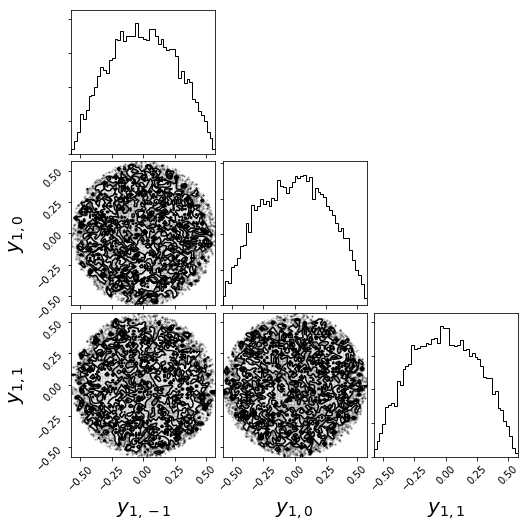

In [3]:
sampler = compute(l=1)

In the paper we showed that *PSD* is guaranteed if $y_{1,-1}^2 + y_{1,0}^2 + y_{1,1}^2 \le \frac{1}{3}$. This corresponds to a 3D ball of radius $\sqrt{\frac{1}{3}} \approx 0.577$ centered at the origin. And that's exactly what we get!

Let's go to $l = 2$ and do the same thing:

100%|██████████| 100000/100000 [00:45<00:00, 2209.84it/s]


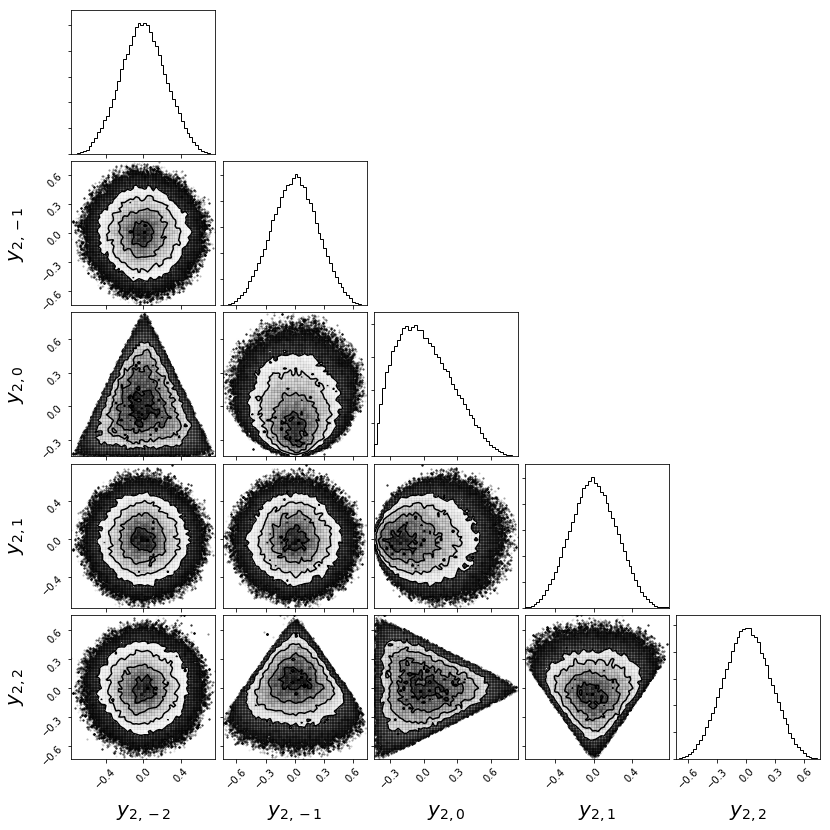

In [4]:
compute(l=2, nsteps=100000)

Our parameter space is no longer so simple! As far as we know, there's no analytic expression to summarize the values of these coefficients that guarantee *PSD*. But the numerical solver in `starry` is fairly fast, so calling `map.psd()` is the way to go.

**NOTE: If you squint, you'll notice that there are a few outliers in the plots above. These cases are rare, but sometimes the numerical solver will fail to converge and miss negative regions in the map. But since this is quite uncommon, this method should still be fine to enforce physical priors in optimization problems. Just keep this caveat in mind...**

Finally, just for fun, let's do $l=3$:

100%|██████████| 100000/100000 [01:18<00:00, 1269.43it/s]


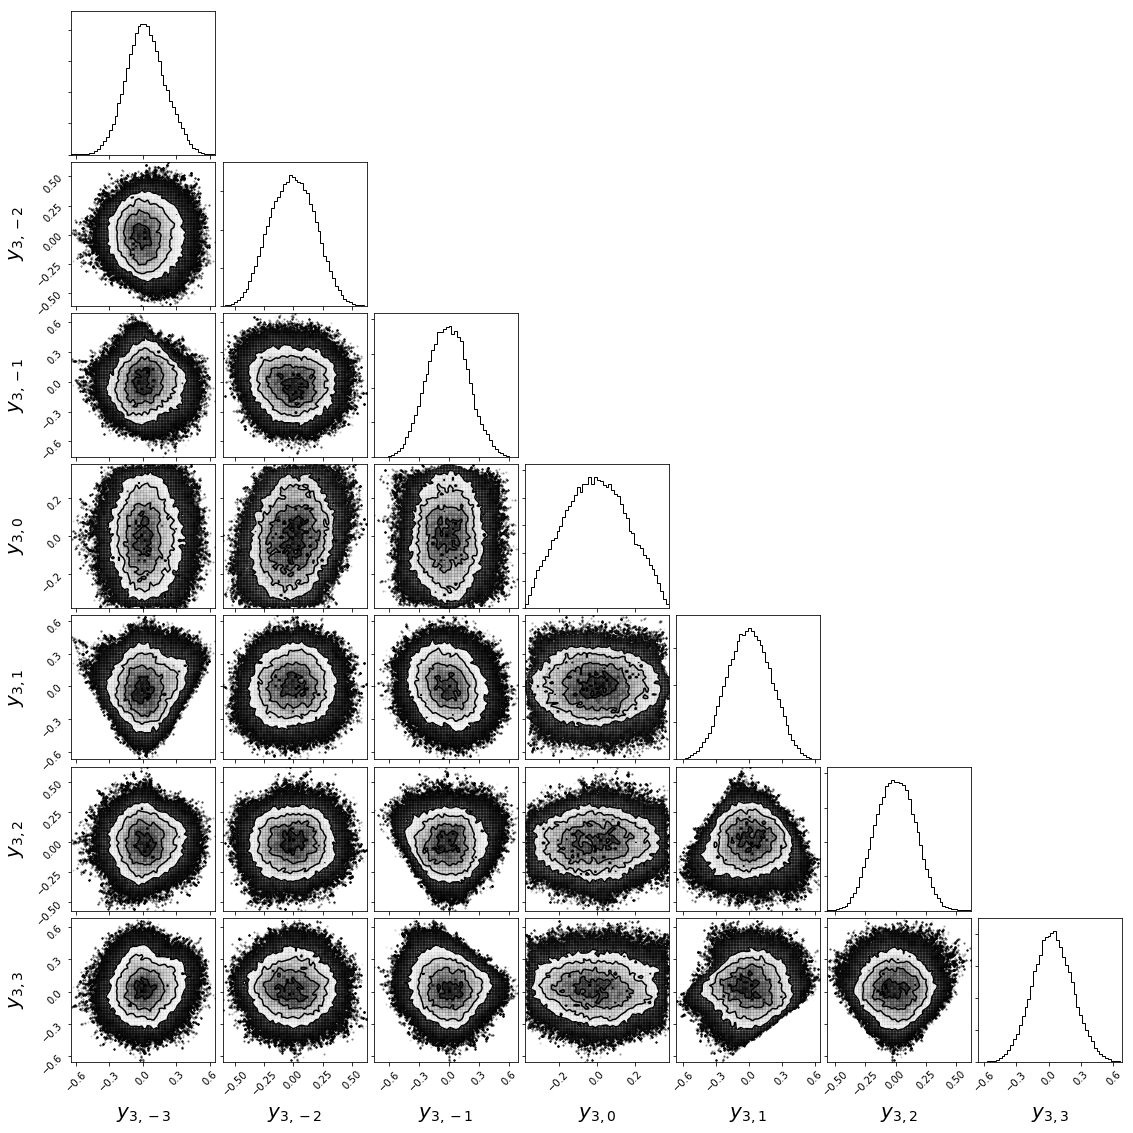

In [5]:
sampler = compute(l=3, nsteps=100000)